In [1]:
import numpy as np
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
DATA_PATH = "/jupyteruser/31376238/UTKFace_Data/UTKFace_Data"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 200
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [3]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        #print(filepath)
        return None, None, None

In [4]:
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

files = list_files(DATA_PATH)

In [5]:
attributes = list(map(parse_filepath, files))

In [6]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df = df.drop_duplicates()
#df.head()

# Exploratory Analysis

## Raw Data

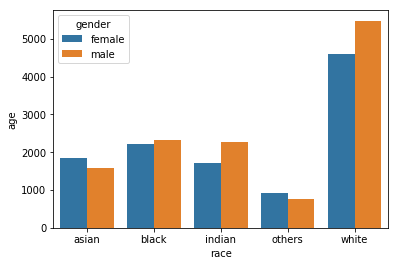

In [7]:
x = pd.DataFrame(df.groupby(by=['race', 'gender'])['age'].count())
x.reset_index(inplace=True)
ax = sns.barplot(x="race", y="age", hue="gender", data=x)

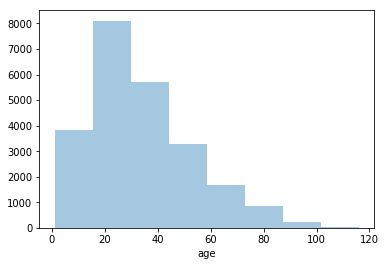

In [8]:
sns.distplot(df['age'], bins = 8, kde=False);

## Preprocessing
### Create Baseline Dataset

First we remove ages that are likely to make gender identification challenging.

In [9]:
df = df[(df['age'] > 10) & (df['age'] < 65)]

Let's revisit the EDA using the baseline dataset.  This dataset ("df") will be used for our baseline model.

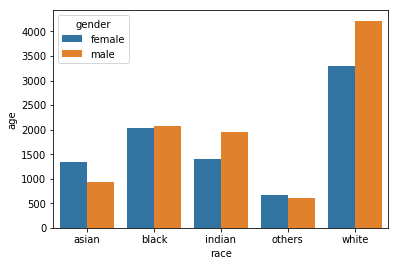

In [10]:
y = pd.DataFrame(df.groupby(by=['race', 'gender'])['age'].count())
y.reset_index(inplace=True)
ax = sns.barplot(x="race", y="age", hue="gender", data=y)

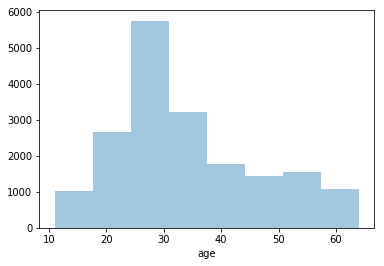

In [11]:
sns.distplot(df['age'], bins = 8, kde=False);

### Create Ethnically Balanced Dataset (skip this part for now)

The baseline dataset contain 18,529 images (see below).

In [12]:
base_len = len(df)
print('Baseline dataset length:{0}'.format(base_len))

Baseline dataset length:18529


There are 10 gender-ethnicity combinations. Let's create a balanced data set similar in size to the baseline dataset, but with equally distributed gender-ethniticy combinations each containing 1,852 images (see below).

In [13]:
bal_subgrp_len = base_len // 10
print('Balanced subgroup length:{0}'.format(bal_subgrp_len))

Balanced subgroup length:1852


To achive this, we will randomly downsample subgroups with more than 1,852 images, and upsample subgroups with fewer than 1,852 images.

In [ ]:
# get all gender-ethnicity combinations


# create dataframe with equally distributed subgroups (without age consideration)
def gen_df(df, rows, seed):
    if len(df) > rows:
        new_df = df.sample(n=rows,random_state=seed)
    else:
        x = len(df) // rows
        for i in range(x)



Let's revisit the EDA using the balanced dataset ("df_bal").

In [ ]:
y = pd.DataFrame(df.groupby(by=['race', 'gender'])['age'].count())
y.reset_index(inplace=True)
ax = sns.barplot(x="race", y="age", hue="gender", data=y)

In [ ]:
sns.distplot(df['age'], bins = 8, kde=False);

-----need to add  more here----

# Custom Generator Function

In [7]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, for_training, batch_size=16):
    images, ages, races, genders, files = [], [], [], [], []
    while True:
        for i, r in df.iterrows():
            file, age, race, gender = r['file'], r['age'], r['race'], r['gender']
            
            # image preprocessing
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            
            ages.append(age)
            races.append(race)
            gender_id = GENDER_ID_MAP[gender]
            genders.append(to_categorical(gender_id, 2))
            files.append(file)
            if len(images) >= batch_size:
                if for_training:
                    yield np.array(images), np.array(genders)
                else:
                     yield np.array(images), np.array(genders), np.array(races), np.array(ages), np.array(files)
                images, ages, races, genders, files = [], [], [], [], []
        if not for_training:
            break

# Custom Train Val Test Split Function

In [8]:
def train_val_test_split(df, test_size, val_size, random_state):

    model_df , test_df = train_test_split(df, test_size = test_size, shuffle = True , random_state = random_state,
                                                  stratify = df[['gender','race']])

    train_df , val_df = train_test_split(model_df, test_size = val_size, shuffle = True , random_state = random_state,
                                                  stratify = model_df[['gender','race']])

    return train_df, val_df, test_df

# Model

In [9]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape= (IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=2, activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[gender_output])
model.compile(optimizer='rmsprop', 
              loss={'gender_output': 'categorical_crossentropy'},
              metrics={'gender_output': 'accuracy'})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 196, 196, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 96)        55392     
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 96)        384       
__________

# Baseline Run

In [10]:
run_type = 'baseline'
epochs = 1

In [11]:
train_df, val_df, test_df = train_val_test_split(df=df, test_size=0.1, val_size=0.3, random_state=44)

len(train_df), len(val_df), len(test_df)

(14933, 6401, 2371)

In [12]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(train_df, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(val_df, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_df)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val_df)//valid_batch_size)
                    

Epoch 1/1
233/233 [==============================] - 151s 648ms/step - loss: 0.6238 - acc: 0.7156 - val_loss: 0.4747 - val_acc: 0.7756


In [ ]:
model.save_weights(WEIGHTS_PATH + '/' + run_type + '_' + str(epochs) + '_epochs.w')

In [ ]:
#model.load_weights(folder + '/cropped_conv_gender_epochs10_binary.w')

In [13]:
test_gen = get_data_generator(test_df, for_training=False, batch_size=128)
true_list = []
pred_list = []
race_list = []
age_list  = []
file_list = []
for i, batch in enumerate(test_gen):
    batch_pred = model.predict_on_batch(batch[0]).tolist()
    batch_true = batch[1].tolist()
    batch_race = batch[2].tolist()
    batch_age  = batch[3].tolist()
    batch_file = batch[4].tolist()    

    for t in batch_true:
        true_list.append(t)
    for p in batch_pred:
        pred_list.append(p)
    for r in batch_race:
        race_list.append(r)
    for a in batch_age:
        age_list.append(a)        
    for f in batch_file:
        file_list.append(f)          

In [14]:
gender_true = np.array(true_list).argmax(axis=-1)
gender_pred = np.array(pred_list).argmax(axis=-1)
races = np.array(race_list)
ages = np.array(age_list)
files = np.array(file_list)

In [15]:
df_preds = pd.DataFrame(list(zip(races, gender_true, gender_pred, ages, files)), 
                        columns=['race','gender_true','gender_pred','age','file'])

In [16]:
df_preds.head()

,race,gender_true,gender_pred,age,file
0,white,1,0,33.0,/jupyteruser/31376238/UTKFace_Data/UTKFace_Dat...
1,indian,0,0,35.0,/jupyteruser/31376238/UTKFace_Data/UTKFace_Dat...
2,indian,0,0,21.0,/jupyteruser/31376238/UTKFace_Data/UTKFace_Dat...
3,white,1,1,40.0,/jupyteruser/31376238/UTKFace_Data/UTKFace_Dat...
4,white,1,1,39.0,/jupyteruser/31376238/UTKFace_Data/UTKFace_Dat...


In [18]:
unique_races = df_preds['race'].unique()

In [20]:
class color:
   BROWN = '\033[91m'
   GREEN = '\033[92m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [21]:
for race in unique_races: 
    print(color.BOLD + color.BROWN + "Classification report for race " + race.upper() + color.END, "\n",)
    print(classification_report(df_preds[df_preds['race'] == race]['gender_true'], 
                                df_preds[df_preds['race'] == race]['gender_pred']))

Classification report for race WHITE 

              precision    recall  f1-score   support

           0       0.88      0.62      0.73       534
           1       0.67      0.90      0.77       451

   micro avg       0.75      0.75      0.75       985
   macro avg       0.77      0.76      0.75       985
weighted avg       0.78      0.75      0.75       985

Classification report for race INDIAN 

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       221
           1       0.78      0.86      0.82       165

   micro avg       0.84      0.84      0.84       386
   macro avg       0.83      0.84      0.84       386
weighted avg       0.84      0.84      0.84       386

Classification report for race BLACK 

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       228
           1       0.78      0.82      0.80       211

   micro avg       0.80      0.80      0.80       439
   macro a

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    axes[0].plot(history.history['acc'], label='Gender Train accuracy')
    axes[0].plot(history.history['val_acc'], label='Gender Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('g:{}, r:{}'.format(ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('g:{}, r:{}'.format(ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])
    

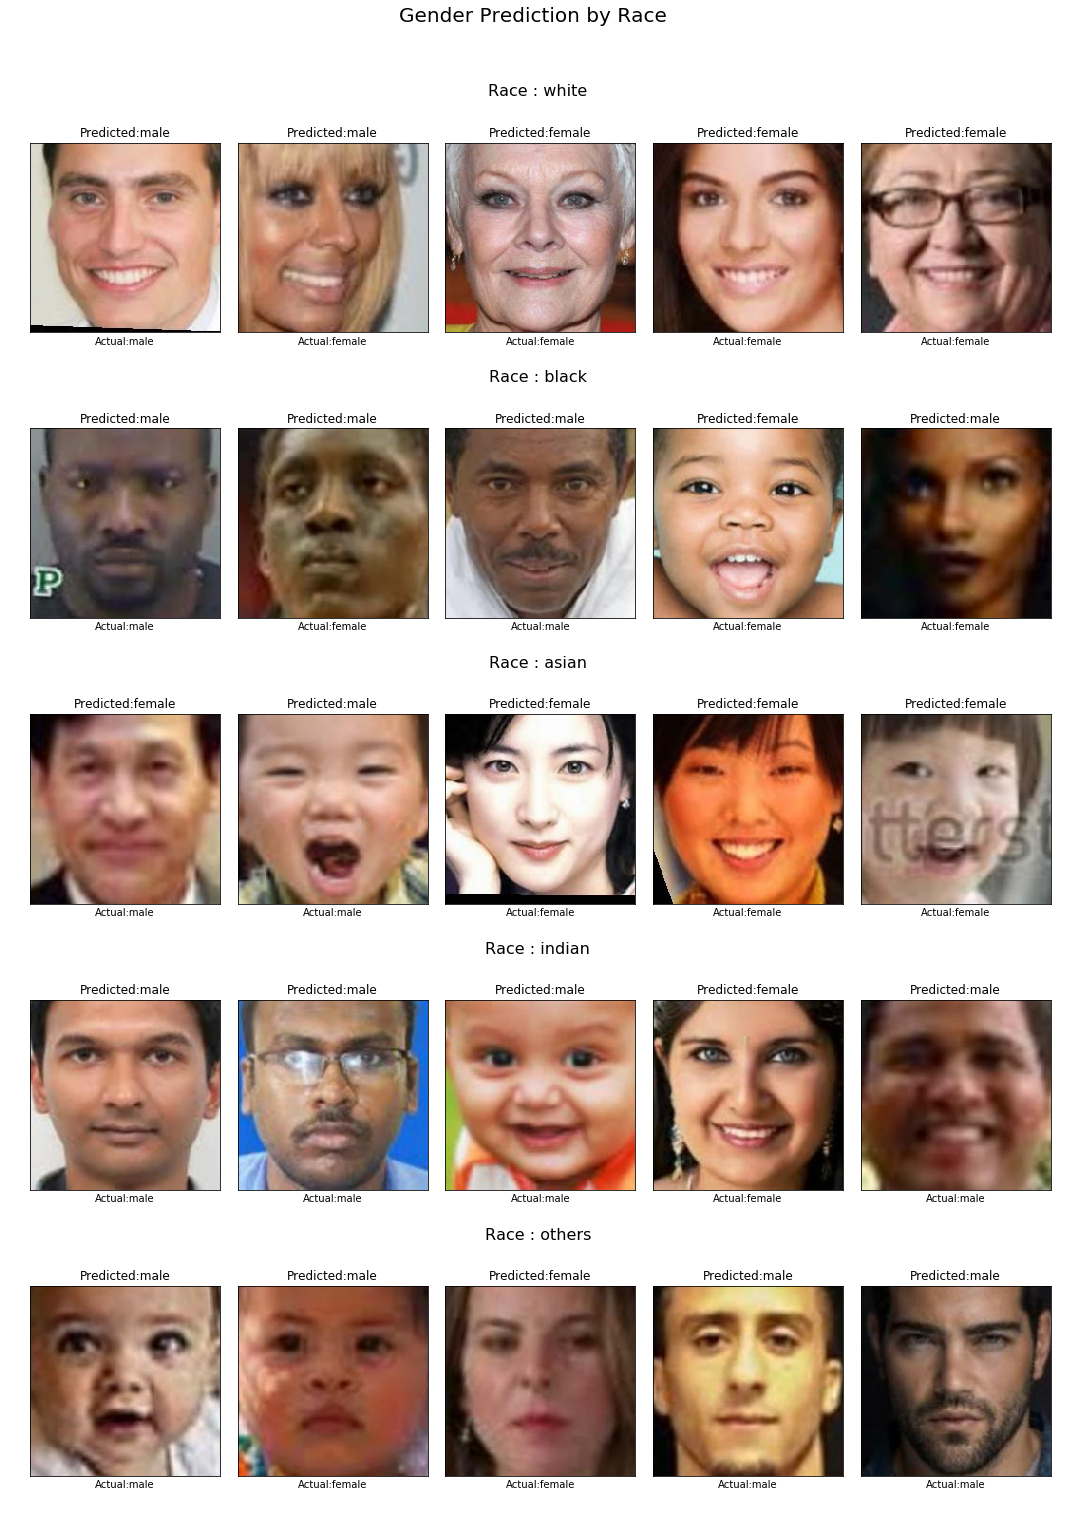

In [17]:
import warnings
warnings.filterwarnings("ignore")

fig, big_axes = plt.subplots( figsize=(15.0, 20.0) , nrows=5, ncols=1, sharey=True) 
fig.suptitle('Gender Prediction by Race', fontsize=20, y=1.05)

for row, big_ax in enumerate(big_axes):
    big_ax.set_title("Race : %s \n" %ID_RACE_MAP[row], fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False


for i in range(1,26):
    ax = fig.add_subplot(5,5,i)
    key = int((i-1)/5)
    race_df = df_preds[df_preds['race']==ID_RACE_MAP[key]]
    random_img = np.random.choice(race_df.index)
    img = plt.imread(race_df['file'].loc[random_img]);
    ax.imshow(img)
    ax.set_title("subplot: %s" %key)
    ax.set_title('Predicted:{}'.format(ID_GENDER_MAP[race_df['gender_pred'].loc[random_img]]))
    ax.set_xlabel('Actual:{}'.format(ID_GENDER_MAP[race_df['gender_true'].loc[random_img]]))
    ax.set_xticks([])
    ax.set_yticks([])

fig.set_facecolor('w')
plt.tight_layout()
plt.show()